# README
Adjust `Timesteps` and `feature_used` as noted.
---

In [1]:
from util_input_output_model import *
from collections import defaultdict
from datetime import timedelta
import tensorflow as tf
import numpy as np
import pandas as pd
import time
provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Songkhla','Khon Kaen']

features = ['PM2.5','WindDir','Wind Speed(km/h)','Temp(C)','Cambodia_frp','Myanmar_frp','Thailand_frp','Lao_PDR_frp']
tf.__version__

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'2.5.0-rc1'

In [128]:
# Province and its model
province = 'Kanchanaburi'
path = "Models\Khon Kaen_run_2021_04_27-16_20_46_kind_of_final.h5"

# Feature used
feature_used = features

# Number of timesteps
timesteps = 360

model = tf.keras.models.load_model(path)
print("Input shape =",model.layers[0].input_shape)
print(model.summary())

Input shape = (None, 360, 8)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 360, 100)          43600     
_________________________________________________________________
dropout_12 (Dropout)         (None, 360, 100)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60)                38640     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 72)                4392      
Total params: 86,632
Trainable params: 86,632
Non-trainable params: 0
_________________________________________________________________
None


## Prepare data

In [3]:
Train_data, X_train, Y_train = prepare_train_data(timesteps, feature_used = feature_used)
Test_data, X_test, Y_test = prepare_test_data(Train_data, timesteps, feature_used = feature_used)

dif : 355
2019-03-18 08:00:00
base = 2019-03-18 12:00:00
dif : 349
2019-03-18 08:00:00
base = 2019-03-18 18:00:00
dif : 343
2019-03-18 08:00:00
base = 2019-03-19 00:00:00
dif : 337
2019-03-18 08:00:00
base = 2019-03-19 06:00:00


## Scale data

In [4]:
x_train_scalers, y_train_scalers, X_train_scaled, Y_train_scaled = scale_data(X_train, Y_train, Train_data)

X_test_scaled = defaultdict(lambda: [])
Y_test_scaled = defaultdict(lambda: [])

for p in provinces:
    for e in X_test[p]:
        X_test_scaled[p].append(x_train_scalers[p].transform(e))
    for e in Y_test[p]:
        Y_test_scaled[p].append(y_train_scalers[p].transform(e))

## Check the shape

In [5]:
x_, y_ = {}, {}

for p in provinces:
    x_[p] = {"Train": np.array(X_train_scaled[p]),
             "Test": np.array(X_test_scaled[p])}
    
    y_[p] = {"Train": np.array(Y_train_scaled[p]).squeeze(axis=2),
             "Test": np.array(Y_test_scaled[p]).squeeze(axis=2)}

    print(p)
    print(f'X Train: {x_[p]["Train"].shape}')
    print(f'Y Train: {y_[p]["Train"].shape}')
    print(f'X Test: {x_[p]["Test"].shape}')
    print(f'Y Test: {y_[p]["Test"].shape}\n')

Bangkok
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)

Chanthaburi
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)

Chiang Mai
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)

Kanchanaburi
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)

Songkhla
X Train: (4366, 360, 8)
Y Train: (4366, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)

Khon Kaen
X Train: (1936, 360, 8)
Y Train: (1936, 72)
X Test: (1454, 360, 8)
Y Test: (1454, 72)



## Assign variables

In [129]:
x_feed, y_feed = x_[province]['Train'], y_[province]['Train']
x_eval, y_eval = x_[province]['Test'], y_[province]['Test']

In [32]:
# Last check for null values
print(np.isnan(x_feed).any())
print(np.isnan(y_feed).any())
print(np.isnan(x_eval).any())
print(np.isnan(y_eval).any())

False
False
False
False


# Evaluation

In [72]:
model.evaluate(x_eval, y_eval)

46/46 [==============================] - 6s 116ms/step - loss: 0.0120


0.011965648271143436

In [130]:
from sklearn.metrics import mean_squared_error as mse
pred = model(x_eval)
rmse = []
print('province :', province)
for i in range(len(pred)):
    p = y_train_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = Y_test[province][i].values
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)

province : Kanchanaburi


12.674762188147326

province = Khon Kaen


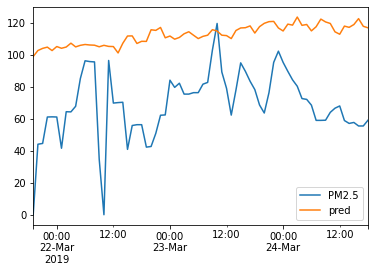

In [118]:
i = 13
print('province =',province)
h = y_train_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
k = Y_test[province][i].copy()
k['pred'] = h
k.plot();

In [88]:
np.argmax(rmse)

1347

## Save the predictions

In [61]:
prediction_1D = []

for e in pred:
    prediction_1D.append(y_train_scalers[province].inverse_transform(e.numpy().reshape((-1,1))))

prediction_1D = np.array(prediction_1D).reshape((-1,1))
prediction_1D.shape

(104688, 1)

In [62]:
province_prediction = pd.DataFrame({province:prediction_1D.ravel()})
province_prediction

,Songkhla
0,27.691200
1,27.704931
2,27.823921
3,27.798691
4,27.793245
...,...
104683,13.409019
104684,13.500948
104685,14.194033
104686,13.497429


In [64]:
#province_prediction.to_csv(f"./predictions/{province}_pred.csv")